# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

#todo riscrivere outcomoe in diabete

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project...

In [ ]:
%pip install pgmpy

## Dataset

768 rows, 9 columns

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.

From the data set in the (.csv) file we can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis

In [6]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In the dataset there are 268 patients with diabetes and 500 without. The Outcome column is imbalanced: only about 35% of the entries have diabetes.

In [ ]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

In [ ]:
###################
count_1 = 0
count_2 = 1
for i in range(df_raw.shape[0]):
    if df_raw["Insulin"][i] < 1 and df_raw["Outcome"][i] == 1 :
        count_1 += 1
print("presumibilmente ci sono ",count_1,"pazienti con diabete di tipo 1")

### Data cleaning

Vediamo che ci sono tanti valori nulli nel dataset. Sarebbero da togliere dato che sono dei NaN. Allo stesso tempo possiamo usare questa cosa per iniziare un downsample dei dati con Outcome '0'

In the dataset there are many null values that we have to handle. We decided to remove them instead of using statistical methods to predict the missing values, since we have few data and we want them to be as much predictive as possible. By the way, we have to consider that null values of Insulin are interesting data since they usually indicate the presence of Diabetes

In [51]:
for item in df_raw.columns :
    if item != "Outcome":
        print("In the column", item,"there are",(df_raw[item].values == 0).sum(),"null values")

In the column Pregnancies there are 111 null values
In the column Glucose there are 5 null values
In the column BloodPressure there are 35 null values
In the column SkinThickness there are 227 null values
In the column Insulin there are 374 null values
In the column BMI there are 11 null values
In the column DiabetesPedigreeFunction there are 0 null values
In the column Age there are 0 null values


We proceed with the removal of rows that have a null value in the columns: 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI'.  
Previous analysis showed that DiabetesPedigreeFunction column and Age column don't contain any null values.

In [82]:
df_clean = df_raw.copy(deep=True)
df_clean.rename(columns={"Outcome": "Diabetes_2"},inplace=True)

In [83]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness','BMI']
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("Column",item,"has been cleaned")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)
    

Column Glucose has been cleaned
Column BloodPressure has been cleaned
Column SkinThickness has been cleaned
Column BMI has been cleaned


With regard to the Insulin column we consider the fact that a null value of insulin in the blood is a sure sign of the presence of (type 1) Diabetes, so we proceed with removing all the rows that have a null value of both Insuline and Outcome

In [85]:
for i in range(len(df_clean["Insulin"])):
    if df_clean["Insulin"][i] == 0 and df_clean["Diabetes_2"][i] == 0:
        df_clean.drop(labels= i, axis= 0, inplace= True)
print("Column 'Insulin' has been cleaned")
df_clean.reset_index(drop=True, inplace=True)

Column 'Insulin' has been cleaned


In [ ]:
df_clean["Diabetes_1"] = np.zeros(df_clean.shape[0])

for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] == 0 and df_clean["Diabetes_2"][i] == 1:
        df_clean["Diabetes_2"][i] = 0
        df_clean["Diabetes_1"][i] = 1

df_clean['Diabetes_1'] = df_clean['Diabetes_1'].apply(np.int64)

We check now if the dataset is balanced with respect to the Diabetes columns

In [ ]:
print("Total number of patient with diabetes", (df_clean["Diabetes_2"] == 1).sum() + (df_clean["Diabetes_1"] == 1.0).sum())
print("Total number of patient without diabetes", df_clean.shape[0] - ((df_clean["Diabetes_2"] == 1).sum() + (df_clean["Diabetes_1"] == 1.0).sum()))


As we notice there is the need of a balancing of the dataset since the '0' outcomes are 50% more than the '1' outcomes. We deal with this using the resample method provided by sklearn
OVVIAMENTE QUESTO MATCHA LA REALTA'

In [ ]:
from sklearn.utils import resample

In [ ]:
df_positive_outcome = df_clean[df_clean["Outcome"] == 1]
df_negative_outcome = df_clean[df_clean["Outcome"] == 0]
#-----------

df_negative_outcome_downsampled = resample(df_negative_outcome,
             replace=True,
             n_samples=len(df_positive_outcome),
             random_state=42)
print(df_negative_outcome_downsampled.shape)
#-----------------

df_balanced = pd.concat([df_negative_outcome_downsampled, df_positive_outcome])
#-----------

df_balanced.reset_index(drop=True, inplace=True)

print("Total number of Outcomes without diabetes", (df_balanced["Outcome"] == 0).sum())
print("Total number of Outcomes with diabetes", (df_balanced["Outcome"] == 1).sum())


SEMPLICEMENTE FACCIAMO I BIN
We have now a balanced dataset, the next step is to modify the values of columns from continuous values to discrete values. This transition is necessary in order to work with a bayesian network.
The binnarization was made trying to group values ​​into ranges of interest, rather than splitting them into 'n' number of bins.  

In [ ]:
for item in df_clean:
    print("valori di ",item)
    temp = df_clean[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

#### Binnerization

In [105]:
df_bin = df_clean.copy(deep=True)

In [109]:
df_bin.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_2,Diabetes_1
0,3-6,140-200,60-80,30-40,0-5,30+,0.5-0.7,40-50,0,1
1,0-3,70-100,60-80,15-30,50-120,25-30,0-0.2,20-30,0,0
2,0-3,100-140,30-60,30-40,150-250,30+,0.9+,30-40,1,0
3,0-3,70-100,30-60,30-40,50-120,30+,0.2-0.3,20-30,1,0
4,0-3,140-200,60-80,40+,250+,30+,0-0.2,50-60,1,0


In [106]:
#dictionary di configurazione per la binnerizzazione

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,11,18],
            "labels": ["0-3","3-6","6-11","11+"]},

        "Glucose" :{
            "bins" : [70,100,140,np.max(df_clean["Glucose"])],
            "labels" : ["70-100","100-140","140-200"]},

        "BloodPressure" :{
            "bins" : [29,60,80,85,90,100,110],
            "labels" : ["30-60","60-80","80-85","85-90","90-100","100-110"]},

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_clean["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,5,25,50,120,150,250,np.max(df_clean["Insulin"])],
            "labels" : ["0-5","5-25","25-50","50-120","120-150","150-250","250+"]},
            
        "BMI" :{
            "bins" : [19,25,30,np.max(df_clean["BMI"])],
            "labels" : ["19-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_clean["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_clean["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [107]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_clean[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

In [ ]:
for item in df_bin:
    print("valori di ",item)
    temp = df_bin[item].unique()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

In [ ]:
#Visualization of the binerized features distributions

fig, axs = plt.subplots(5, 2, figsize=(18,20))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1])


Now that bins have been correctly crated, we move to desing the network

# Network


In this chapter we will build the network by analyzing correlations between the columns and scientific papers related to the topic. We will then explore a variety of methods related to the analysis of Bayesian Networks.

Analyzing the correlations between the columns of the dataframe can help us reason about the causal relationships between them. 

<AxesSubplot:>

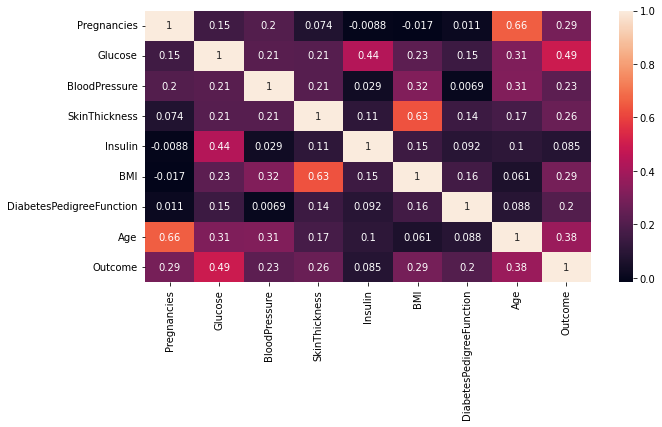

In [62]:
corr = df_clean.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

Age - pregnancies  
Age - outcome  
Outcome - glucose  
insulin - glucose  
insulin - skinthickness  
bmi - skinthickness  

### Showing the network

We show a graphical preliminary overview of the network using the visual library daft of pgmpy.  
The acronyms related to dataset attributes are the followings:

...


In [ ]:
%pip install daft

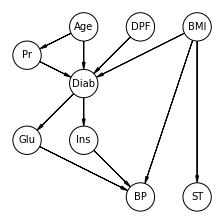

In [63]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 4))
pgm.add_node(daft.Node('DPF', "DPF", 3, 4))
pgm.add_node(daft.Node('BMI', "BMI", 4, 4))

pgm.add_node(daft.Node('Pr', "Pr", 1, 3.5))

pgm.add_node(daft.Node('Diab', "Diab", 2, 3))

pgm.add_node(daft.Node('Glu', "Glu", 1, 2))
pgm.add_node(daft.Node('Ins', "Ins", 2, 2))

pgm.add_node(daft.Node('BP', "BP", 3, 1))
pgm.add_node(daft.Node('ST', "ST", 4, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab')
pgm.add_edge('DPF', 'Diab')
pgm.add_edge('Age', 'Diab')
pgm.add_edge('BMI','Diab')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab', 'Glu')
pgm.add_edge('Diab', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Ins', 'BP')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [64]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('Age','Pregnancies'),('Pregnancies', 'Diabetes'),('DiabetesPedigreeFunction', 'Diabetes'),('Age', 'Diabetes'),('BMI','Diabetes'),
('BMI','SkinThickness'),('BMI', 'BloodPressure'),('Diabetes', 'Glucose'),('Diabetes', 'Insulin'),('Glucose', 'BloodPressure'),('Insulin','BloodPressure')])

c:\Users\Luca\.virtualenvs\ML4downsyndrome-D1DocbTt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [65]:
# Showing all the nodes of the model
model.nodes()

NodeView(('Age', 'Pregnancies', 'Diabetes', 'DiabetesPedigreeFunction', 'BMI', 'SkinThickness', 'BloodPressure', 'Glucose', 'Insulin'))

In [ ]:
# Showing all the edges of the model
model.edges()

In [ ]:
# Local independencies of a single node
model.local_independencies("Diabetes")

In [ ]:
model.local_independencies("SkinThickness")

In [ ]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("Glucose", "Insuline"))
print(model.is_dconnected("Glucose", "Insuline",observed=["Diabetes"] ))

In [66]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with resepect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with resepect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insuline", "Diabetes")

Node Glucose is irrelevant with resepect to Insuline given the evidence Diabetes


In [ ]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes')

In [ ]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

### Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [67]:
from pgmpy.estimators import BayesianEstimator

In [68]:
df = df_bin.rename(columns = {'Outcome':'Diabetes'}) #column names and node names must be the same

In [ ]:
df.head()

In [69]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of Age:
+------------+-----------+
| Age(20-30) | 0.591324  |
+------------+-----------+
| Age(30-40) | 0.200913  |
+------------+-----------+
| Age(40-50) | 0.127854  |
+------------+-----------+
| Age(50-60) | 0.06621   |
+------------+-----------+
| Age(60+)   | 0.0136986 |
+------------+-----------+ 

CPT of Pregnancies:
+-------------------+-----+----------------------+
| Age               | ... | Age(60+)             |
+-------------------+-----+----------------------+
| Pregnancies(0-3)  | ... | 0.20833333333333334  |
+-------------------+-----+----------------------+
| Pregnancies(11+)  | ... | 0.041666666666666664 |
+-------------------+-----+----------------------+
| Pregnancies(3-6)  | ... | 0.20833333333333334  |
+-------------------+-----+----------------------+
| Pregnancies(6-11) | ... | 0.5416666666666666   |
+-------------------+-----+----------------------+ 

CPT of Diabetes:
+--------------------------+-----+--------------------------------+
| Age                

In [ ]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

In [ ]:
#Cardinality of all model nodes
model.get_cardinality()

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [70]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [ ]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies
print('Probability of having diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '0-3'}))

print('Probability of having diabetes with more than 11 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '11+'}))

In [77]:
#Evidential inference (explanation): probability of having diabetes given that the patient has very high insulin level
#TODO add evidence of insulin = 0
print(infer.query(["Diabetes"],evidence={"Insulin": '250+'}))

+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4847 |
+-------------+-----------------+
| Diabetes(1) |          0.5153 |
+-------------+-----------------+


In [ ]:
#Intercausal inference (explaining away): why she has high blood pressure given the fact that she hasn't diabetes
print(infer.query(["BMI"],evidence={"BloodPressure": '100-110' , "Diabetes": 0}))

Maximum a posteriori (MAP) queries find the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variable), given observations of some evidence variables.
The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [ ]:
#Infer MAP queries
print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '70-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes': 1}))

## Approximate Inference

In [ ]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [ ]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [ ]:
# Sampling from an empty network
print(infer.query(variables=["Diabetes"], n_samples=100)) 

In [ ]:
# Showing the convergence increasing number of samples
print(infer.query(variables=["BloodPressure"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["BloodPressure"], n_samples=10000)) #approximate probability with an high number of samples

print(VariableElimination(model).query(["BloodPressure"]))      #true probability

In [ ]:
print(infer.query(variables=["Diabetes"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["Diabetes"], n_samples=100)) #approximate probability with a medium number of samples

print(infer.query(variables=["Diabetes"], n_samples=10000)) #approximate probability with an high number of samples

print('True probability:')
print(VariableElimination(model).query(["Diabetes"]))      #true probability

We can observe that with a small number of samples we don't even find all the possible events for BloodPressure.

In [ ]:
# Likelihood weighting
#let's see the results of a sampling process
print(inference.likelihood_weighted_sample( size=10)) #size: number of samples


In [ ]:
# We observe the distribution obtained to derive the approx probabilities
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes"], joint=True))

In [ ]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes"]))

We observe that, given the same number of samples, sampling from an empty network, likelihood weighting and rejection sampling give us different results. This was expected as we would need more samples to reach convergence for all theese three methods.

# Conclusions

Now that we have explored some functionalities of pgmpy to deal with our network we will explore our model to see if we can get some useful insights about diabetes and the related fetures from what the model has learned using the provided dataset.